In [2683]:
import random
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import statistics
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque

In [2684]:
def generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup): 
    matrice = [[float('inf') for _ in range(num_sommets)] for _ in range(num_sommets)]
    intervalles = {}

    for i in range(num_sommets):
        intervalle_start = random.randint(0, max_intervalle_inf)
        intervalle_end = intervalle_start + random.randint(max_intervalle_inf, max_intervalle_sup)
        intervalles[i] = (intervalle_start, intervalle_end)

    connected = set([0]) 
    while len(connected) < num_sommets:
        min_edge = (None, None, float('inf'))
        for u in connected: 
            for v in range(num_sommets):
                if v not in connected and u != v: 
                    poids = random.randint(1, max_poids_arete)
                    if poids < min_edge[2]:
                        min_edge = (u, v, poids)
        u, v, poids = min_edge
        if u is not None and v is not None:
            matrice[u][v] = poids
            matrice[v][u] = poids
            connected.add(v)

    for i in range(num_sommets):
        for j in range(i + 1, num_sommets):
            if matrice[i][j] == float('inf') and random.choice([True, False]):
                poids = random.randint(1, max_poids_arete)
                matrice[i][j] = poids
                matrice[j][i] = poids

    return np.array(matrice), intervalles


In [2685]:
#Variables nécessaires
num_sommets = 5
max_poids_arete = 10
max_intervalle_inf = 20
max_intervalle_sup = 100

# Génération des données
tsp_matrice, tsp_intervalles = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)

# Afficher la matrice
print("\nMatrice d'adjacence:")
for row in tsp_matrice:
    print(row)

# Afficher les intervalles
print("\nIntervalles des sommets")
print(tsp_intervalles)


Matrice d'adjacence:
[inf inf  1.  1. 10.]
[inf inf  3. inf inf]
[ 1.  3. inf  2.  9.]
[ 1. inf  2. inf  2.]
[10. inf  9.  2. inf]

Intervalles des sommets
{0: (10, 48), 1: (8, 94), 2: (13, 86), 3: (4, 49), 4: (14, 45)}


In [2686]:
def plot_route(path, points, matrice):
    plt.figure(figsize=(10, 5))
    plt.scatter(points[:, 0], points[:, 1], c='blue')

    start_node = path[0]
    plt.scatter(points[start_node, 0], points[start_node, 1], c='red', label='Start Node')

    for idx, point in enumerate(points):
        plt.text(point[0], point[1], str(idx), fontsize=12, ha='right', va='bottom')

    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        plt.plot([points[from_node, 0], points[to_node, 0]], 
                 [points[from_node, 1], points[to_node, 1]], 'k-')
        mid_point = (points[from_node] + points[to_node]) / 2
        weight = matrice[from_node][to_node]
        plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    from_node = path[-1]
    to_node = path[0]
    plt.plot([points[from_node, 0], points[to_node, 0]], 
             [points[from_node, 1], points[to_node, 1]], 'k-')
    mid_point = (points[from_node] + points[to_node]) / 2
    weight = matrice[from_node][to_node]
    plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    plt.title('Meilleur Itinéraire Trouvé') 
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

In [2687]:
def plot_vi(path_lengths, best_path_lengths): 
    plt.figure(figsize=(10, 5))
    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Valeur", fontsize=16) 
    plt.plot(range(len(path_lengths)), path_lengths, label='Longueur du chemin courant')
    plt.plot(range(len(best_path_lengths)), best_path_lengths, label='Meilleure longueur du chemin', linestyle='--')
    plt.legend()
    plt.title("Évolution des longueurs de chemin au cours des itérations")
    plt.grid(True)
    plt.show() 

In [2688]:
# Paramètres de la colonie de fourmis
num_ants = 10
num_iterations = 100
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_constant = 100

In [2689]:
# Renvoie si le mouvement est possible et le poids à ajouter
def is_edge_valid(tsp_matrice, num_sommets, from_node, to_node, current_length, visited, num_vertice_taken):
    weight = tsp_matrice[from_node][to_node]

    # Vérifie que l'arete existe et qu'elle n'a pas été empreintée plus de fois que le nombre de sommets
    if weight == np.inf or ((from_node, to_node) in num_vertice_taken and num_vertice_taken[(from_node, to_node)] > num_sommets):
        return (False, 0)

    # Vérifie les conditions des intervalles s'il n'a pas été visité
    if (not to_node in visited) and to_node in tsp_intervalles :
        min_weight, max_weight = tsp_intervalles[to_node]
        if current_length + weight > max_weight:
            return (False, 0) 
        if current_length + weight < min_weight:
            return (True,  (min_weight - current_length))

    return (True, weight)

In [2690]:
# Mise à jour des phéromones
def update_pheromones(best_path, best_path_length, pheromone_matrix):
    # Evaporation des anciennes phéromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Placement des phéromones sur le meilleur chemin trouvé
    for i in range(len(best_path) - 1):
        from_node = best_path[i]
        to_node = best_path[i + 1]
        pheromone_matrix[from_node][to_node] += pheromone_constant / best_path_length

In [2691]:
# Sélection du prochain noeud en fonction des phéromones
def select_next_node(tsp_matrice, num_sommets, current_node, visited, current_length, pheromone_matrix, num_vertice_taken):
    probabilities = []
    total_prob = 0
    pheromone_row = pheromone_matrix[current_node]
    heuristic_row = (1.0 / tsp_matrice[current_node]) ** beta

    # Calcul de probabilité pour tous les sommets
    for node in range(num_sommets):
        if node != current_node:
            valide, poids = is_edge_valid(tsp_matrice, num_sommets, current_node, node, current_length, visited, num_vertice_taken)
            if valide:
                pheromone_level = pheromone_row[node] ** alpha
                heuristic_level = heuristic_row[node]
                probability = pheromone_level * heuristic_level
                probabilities.append((node, probability))
                total_prob += probability

    if total_prob == 0:
        return (None, 0)

    threshold = random.uniform(0, total_prob)
    cumulative_prob = 0

    # Choix des noeuds en fonction des probabilités
    for node, probability in probabilities:
        cumulative_prob += probability
        if cumulative_prob >= threshold:
            valide, poids = is_edge_valid(tsp_matrice, num_sommets, current_node, node, current_length, visited, num_vertice_taken)
            return (node, poids)
    return (None, 0)


In [2692]:
def ant_colony_optimization(tsp_matrice, tsp_intervalles):
    best_path = None
    best_path_length = float('inf')

    path_lengths = deque(())
    best_path_lengths = deque(())
    num_sommets = len(tsp_matrice[0])
    start_time = time.time()  

    # Initialiser les niveaux de phéromones uniquement sur les arêtes
    pheromone_matrix = np.ones((num_sommets, num_sommets))

    for iteration in range(num_iterations):
        
        all_paths = []
        for ant in range(num_ants):
            current_node = random.randint(0, num_sommets - 1)
            path = [current_node]
            visited = {current_node}
            min_weight, max_weight = tsp_intervalles[current_node]
            current_length = min_weight
            num_vertice_taken = {}

            # Construire un chemin
            while len(visited) < num_sommets:
                next_node, weight_to_add = select_next_node(tsp_matrice, num_sommets, current_node, visited, current_length, pheromone_matrix, num_vertice_taken)
                if next_node is None:
                    break
                current_length += weight_to_add
                if (current_node, next_node) in num_vertice_taken:
                    num_vertice_taken[(current_node, next_node)] += 1
                else:
                    num_vertice_taken[(current_node, next_node)] = 1
                current_node = next_node
                path.append(current_node)
                visited.add(current_node)

            # Vérifier si un cycle est formé
            valid, weight = is_edge_valid(tsp_matrice, num_sommets, current_node, path[0], current_length, visited, num_vertice_taken)
            if len(visited) == num_sommets and valid:
                current_length += weight
                path_lengths.append(current_length)
                path.append(path[0])
                all_paths.append((path, current_length))
                if current_length < best_path_length:
                    best_path_length = current_length
                    best_path = path
                best_path_lengths.append(best_path_length)
            

        # Mettre à jour les phéromones uniquement sur le meilleur chemin trouvé
        if best_path:
            update_pheromones(best_path, best_path_length, pheromone_matrix)
    end_time = time.time() 
    execution_time = end_time - start_time 
    return best_path, best_path_length, path_lengths, best_path_lengths , execution_time 

Meilleur chemin trouvé : [3, 0, 3, 0, 2, 1, 2, 0, 2, 0, 3, 4, 3] avec une longueur de 27.00


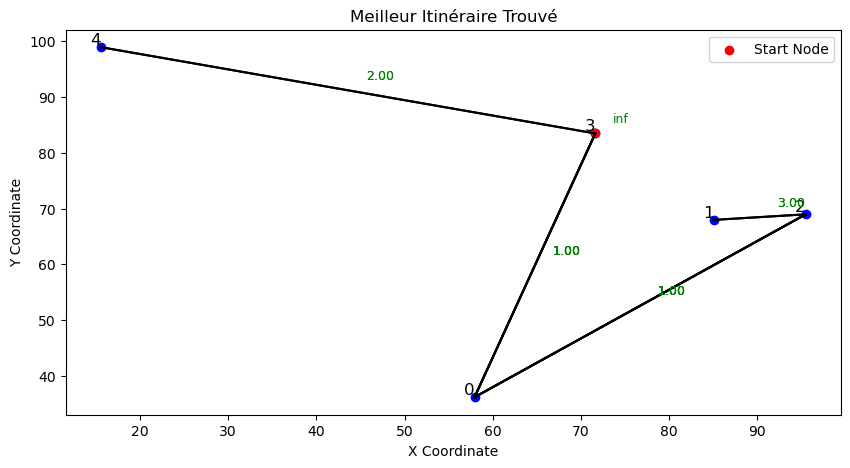

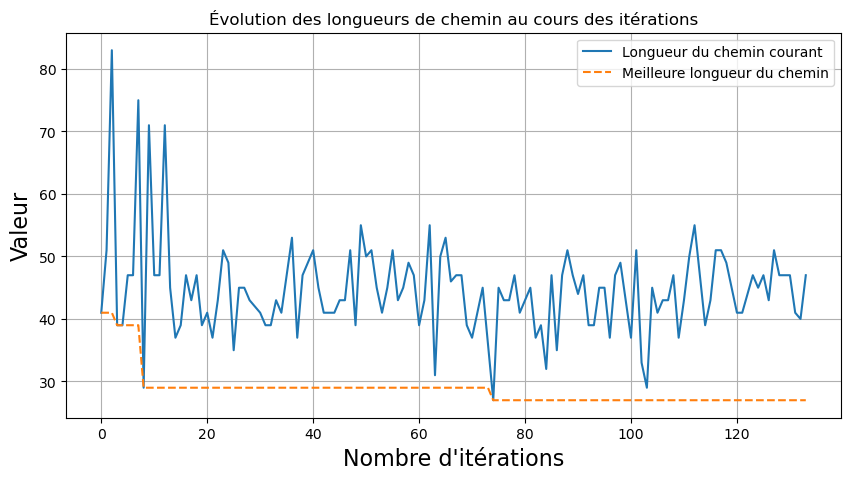

In [2693]:
best_path, best_path_length, path_lengths, best_path_lengths , execution_time  = ant_colony_optimization(tsp_matrice, tsp_intervalles)
# Génération de points aléatoires pour la visualisation du graphe
points = np.random.rand(num_sommets, 2) * 100
print(f"Meilleur chemin trouvé : {best_path} avec une longueur de {best_path_length:.2f}")
# Plot the best route
if best_path:
    plot_route(best_path, points, tsp_matrice)
    plot_vi(path_lengths, best_path_lengths)

Hill

In [2694]:
def calculate_cost(tour, matrice):
    cost = 0
    for i in range(len(tour) - 1):
        if matrice[tour[i]][tour[i + 1]] == float('inf'):
            return float('inf')
        cost += matrice[tour[i]][tour[i + 1]]
    if matrice[tour[-1]][tour[0]] == float('inf'):
        return float('inf')
    cost += matrice[tour[-1]][tour[0]]
    return cost


In [2695]:
def is_within_intervals(tour, intervalles):
    for i in range(len(tour)):
        visit_time = i
        interval_start, interval_end = intervalles[tour[i]]
        if not (interval_start <= visit_time <= interval_end):
            return False
    return True

In [2696]:
def generate_neighbor(tour, matrice, intervalles):
    attempts = 0
    max_attempts = 100  # Early termination threshold
    while attempts < max_attempts:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
        if calculate_cost(tour, matrice) != float('inf') and is_within_intervals(tour, intervalles):
            return tour
        attempts += 1
    return tour  

In [2709]:
def hill_climbing(matrice, intervalles, max_iterations=1000):
    num_sommets = len(matrice)
    max_initial_attempts = 1000
    attempts = 0
    path_lengths = []
    best_path_lengths = [] 

    start_time = time.time() 

    while attempts < max_initial_attempts:
        current_solution = list(range(num_sommets)) + list(np.random.choice(range(num_sommets), size=num_sommets, replace=True))
        random.shuffle(current_solution)

        if calculate_cost(current_solution, matrice) != float('inf') and is_within_intervals(current_solution, intervalles):
            break
        
        attempts += 1

    if attempts == max_initial_attempts:
        end_time = time.time()
        difference_time = end_time - start_time 
        return None, float('inf'), [], [] , difference_time   

    current_cost = calculate_cost(current_solution, matrice)
    best_cost = current_cost

    for _ in range(max_iterations):
        neighbor = generate_neighbor(current_solution.copy(), matrice, intervalles)
        neighbor_cost = calculate_cost(neighbor, matrice)
        
        if neighbor_cost < current_cost and is_within_intervals(neighbor, intervalles):
            current_solution = neighbor
            current_cost = neighbor_cost
        
        path_lengths.append(current_cost)
        
        if current_cost < best_cost:
            best_cost = current_cost
        
        best_path_lengths.append(best_cost)  
    end_time = time.time() 
    execution_time = end_time - start_time 
    return current_solution, current_cost, path_lengths, best_path_lengths , execution_time 

{0: (0, 94), 1: (1, 48), 2: (0, 63), 3: (1, 56), 4: (1, 82)}
[[inf  1.  9.  4.  3.]
 [ 1. inf  3.  6.  6.]
 [ 9.  3. inf  2. inf]
 [ 4.  6.  2. inf inf]
 [ 3.  6. inf inf inf]]


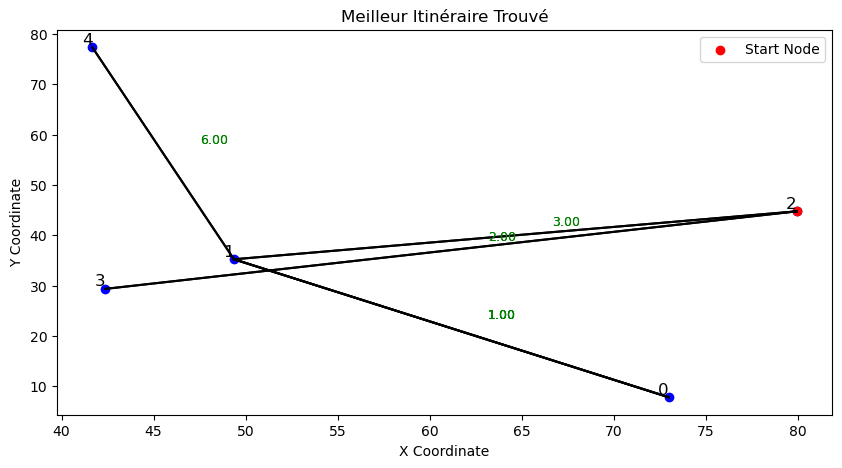

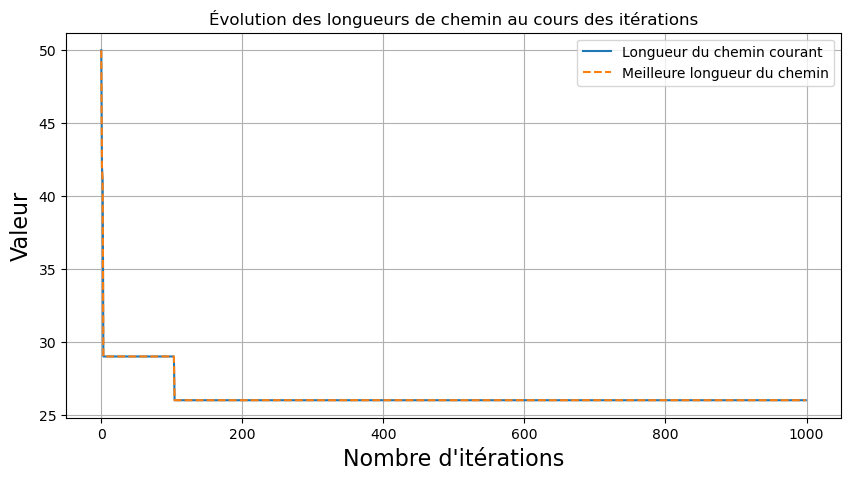

Meilleur chemin: [2, 3, 2, 1, 0, 1, 4, 1, 0, 1]
Longueur de chemin: 26.0


In [2698]:
# Example usage
num_sommets = 5 
max_poids_arete = 10  
max_intervalle_inf = 1
max_intervalle_sup = 100 


tsp_matrice, tsp_intervalles  = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)

solution, cost, path_lengths, best_path_lengths , execution_time   = hill_climbing(tsp_matrice, tsp_intervalles)

print(tsp_intervalles)
print(tsp_matrice)

if solution:
    points = np.random.rand(num_sommets, 2) * 100 
    plot_route(solution, points, tsp_matrice)  
    plot_vi(path_lengths, best_path_lengths)   
    print("Meilleur chemin:", solution)
    print("Longueur de chemin:", cost)
else: 
    print("Pas de solution pour ce graph !") 


In [2699]:
# def plot_taille_matrice_test(sommets):
#     # on affiche la barre de progression
#     nb_steps_bar = (len(sommets)) * nb_test
#     bar = IntProgress(min=0, max=nb_steps_bar, layout={"width": "100%"})
#     display(bar)

#     # pour stocker les résultats
#     moyennes_distances = []
#     meilleur_temps = []
#     pire_temps = []
#     moyennes_temps = []
#     deviations = []

#     for num_sommets in sommets:
#         bornes = deque(())
#         temps = deque(())
#         i = 0
#         duree_mieux = float('inf')
#         duree_pire = 0.0
#         while i < nb_test:
#             tsp_matrice, tsp_intervalles = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)
#             print(i, end=' ', flush=True)
#             best_path, best_path_length, path_lengths, best_path_lengths, execution_time = hill_climbing(tsp_matrice, tsp_intervalles) 
            
#             if best_path is None:
#                 print(f"Hill Climbing didn't find a solution for {num_sommets} cities in iteration {i}.")
#                 bornes.append(float('inf'))
#                 temps.append(execution_time)
#                 i += 1
#                 bar.value += 1
#                 continue
            
#             bornes.append(best_path_length)
#             temps.append(execution_time)
#             duree_mieux = min(duree_mieux, execution_time)
#             duree_pire = max(duree_pire, execution_time)
#             bar.value += 1
#             i += 1

#         moyennes_distances.append(statistics.fmean(bornes))
#         moyennes_temps.append(statistics.fmean(temps))
#         meilleur_temps.append(duree_mieux)
#         pire_temps.append(duree_pire)
#         deviations.append(np.std(bornes))
#         print("\r")
#         print(num_sommets)
#         print("\r")

#     # on cache la barre de progression
#     bar.close()

#     x_values = sommets

#     # affichage de la courbe de moyenne
#     plt.plot(x_values, moyennes_distances, label='Distance moyenne')

#     # affichage de la bande d'écart-type
#     plt.fill_between(x_values,
#                      np.subtract(moyennes_distances, deviations),  # borne haute
#                      np.add(moyennes_distances, deviations),       # borne basse
#                      alpha=.1)                                     # transparence
#     plt.xlabel("Nombre de villes")
#     plt.ylabel("Distance moyenne trouvée")
#     plt.title("Impact du nombre de villes sur les solutions")
#     plt.legend()
#     plt.show()

#     # affichage des courbes de temps d'exécution
#     plt.plot(x_values, moyennes_temps, label='Durée moyenne')
#     plt.plot(x_values, meilleur_temps, label='Durée au mieux')
#     plt.plot(x_values, pire_temps, label='Durée au pire')
#     plt.xlabel("Nombre de villes")
#     plt.ylabel("Temps d'exécution")
#     plt.title("Impact du nombre de villes sur le temps d'exécution")
#     plt.legend()
#     plt.show()

#     # Tracé de la complexité temporelle
#     plt.plot(x_values, moyennes_temps, label='Durée moyenne')
#     plt.xlabel("Nombre de villes")
#     plt.ylabel("Temps d'exécution (secondes)")
#     plt.title("Complexité temporelle de Hill Climbing")
#     plt.legend()
#     plt.show() 
    
# nb_test = 50
# max_intervalle_sup = 1000

# plot_taille_matrice_test([2, 5, 10, 15, 25, 35, 50]) 

Comparison

In [2711]:
def compare_algorithms(iterations=30, num_ants=10, num_iterations_aco=100, alpha=1.0, beta=5.0, evaporation_rate=0.5, Q=100):
    hc_costs = []
    hc_times = []
    aco_costs = []
    aco_times = []

    for _ in range(iterations):
        # Hill Climbing
        start_time = time.time()
        hc_solution, hc_cost, _, _, hc_exec_time = hill_climbing(tsp_matrice, tsp_intervalles)
        end_time = time.time()
        hc_times.append(hc_exec_time)
        if hc_solution is not None:
            hc_costs.append(hc_cost)
        else:
            print("Le Hill Climbing n'a pas trouvé de solution pour cette itération.")

        # ACO
        start_time = time.time()
        _, aco_cost, _, _, aco_exec_time = ant_colony_optimization(tsp_matrice, tsp_intervalles)
        end_time = time.time()
        aco_times.append(aco_exec_time)
        aco_costs.append(aco_cost)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(hc_times, hc_costs, color='blue', label='Hill Climbing')
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Temps de trajet')
    plt.title('Hill Climbing: Temps de trajet vs Temps')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(aco_times, aco_costs, color='red', label='ACO')
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Temps de trajet')
    plt.title('ACO: Temps de trajet vs Temps')
    plt.legend()

    plt.suptitle('Comparaison entre Hill Climbing et ACO.')     
    plt.show()  

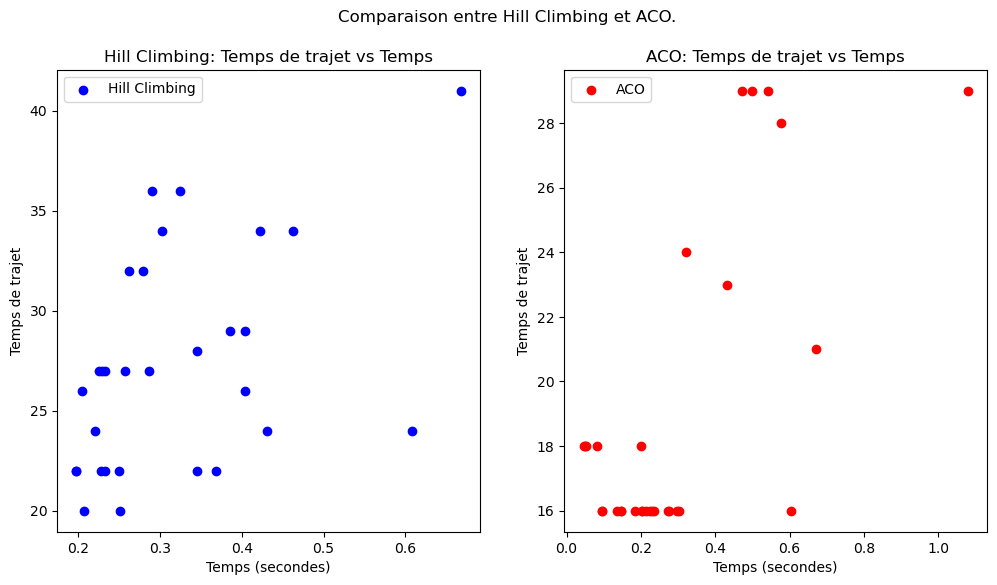

In [2713]:
compare_algorithms(iterations=30, num_ants=10, num_iterations_aco=100, alpha=1.0, beta=5.0, evaporation_rate=0.5, Q=100) 

In [2702]:

#Parametres de test
nb_test = 100 
matrices_test = {}
intervalles_test = {}

#Creation des instances de test
for i in range(nb_test):
    matrice, intervalle = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)
    matrices_test[i] = matrice
    intervalles_test[i] = intervalle
    
print(matrices_test[0], matrices_test[1])  
     

[[inf  1. inf  5.  5.]
 [ 1. inf  1. inf  8.]
 [inf  1. inf  6.  2.]
 [ 5. inf  6. inf  4.]
 [ 5.  8.  2.  4. inf]] [[inf  1.  2.  5.  2.]
 [ 1. inf inf  2. inf]
 [ 2. inf inf inf inf]
 [ 5.  2. inf inf  2.]
 [ 2. inf inf  2. inf]]


In [2703]:
# # Results storage
# results = []

# for i in range(nb_test):
#     matrice = matrices_test[i]
#     intervalles = intervalles_test[i]
#     result = hill_climbing(matrice, intervalles)
#     results.append(result)

# print(results[0]) 

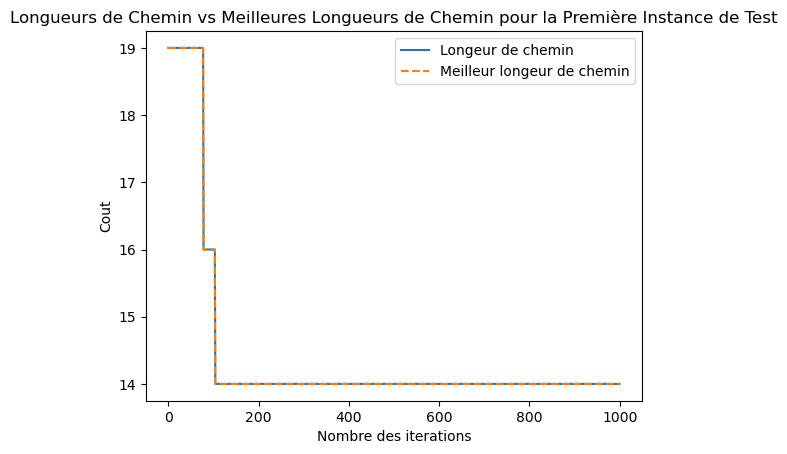

In [2704]:
_, _, path_lengths, best_path_lengths , _ = results[0]

iterations = range(len(path_lengths)) 

plt.plot(iterations, path_lengths, label='Longeur de chemin ')
plt.plot(iterations, best_path_lengths, label='Meilleur longeur de chemin',linestyle='--' )
plt.xlabel('Nombre des iterations')
plt.ylabel('Cout') 
plt.title('Longueurs de Chemin vs Meilleures Longueurs de Chemin pour la Première Instance de Test')
plt.legend()
plt.show()    

In [2705]:
def plot_execution_time_vs_sommets(sommets_list, execution_times):
    plt.plot(sommets_list, execution_times, marker='o')
    plt.xlabel('Nombre de Sommets')
    plt.ylabel("Temps d'Exécution (secondes)")
    plt.title("Temps d'Exécution en Fonction du Nombre de Sommets")
    plt.grid(True)
    plt.show() 

In [2706]:
# # Example usage
# num_sommets = 5 
# max_poids_arete = 10  
# max_intervalle_inf = 1
# max_intervalle_sup = 100
# sommets_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  
# execution_times = [] 
# for num_sommets in sommets_list:
#     matrice, intervalles = generate_tsp_incomplete(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup)
#     result = hill_climbing(matrice, intervalles)
#     execution_times.append(result[4]) 
# plot_execution_time_vs_sommets(sommets_list, execution_times)    